# Data Mining Analysis of Netflix Movies & TV Shows
**Author:** [SULTAN | 56189]  
**Dataset:** netflix_titles.csv (Kaggle)  
**Objective:** End-to-end CRISP-DM: EDA, preprocessing, classification (Movie vs TV Show), clustering, and a content-based recommender.  


In [3]:
!pip install missingno
print('done')

done


In [10]:
# Code cell: imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Apply seaborn styling (safe for all environments)
sns.set_theme()

# Removed missingno (caused ModuleNotFoundError)
# import missingno as msno

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

import joblib
import warnings
warnings.filterwarnings('ignore')

# Removed this to fix the style error
# plt.style.use('seaborn')

%matplotlib inline

print('done')

done


In [11]:
# Load dataset
df = pd.read_csv("netflix_titles.csv")
print("Rows, Columns:", df.shape)
df.head()


Rows, Columns: (8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


## Data Understanding
Show basic info, missingness, and distributions.


In [12]:
# Basic info
df.info()
df.describe(include='all').T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
show_id,8807,8807,s8807,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,8807,2,Movie,6131,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title,8807,8807,Zubaan,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
director,6173,4528,Rajiv Chilaka,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cast,7982,7692,David Attenborough,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,7976,748,United States,2818,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_added,8797,1767,"January 1, 2020",109,NaN,NaN,NaN,NaN,NaN,NaN,NaN
release_year,8807.0,NaN,NaN,NaN,2014.180198,8.819312,1925.0,2013.0,2017.0,2019.0,2021.0
rating,8803,17,TV-MA,3207,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,8804,220,1 Season,1793,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Missing values summary
missing = df.isnull().sum().sort_values(ascending=False)
missing[missing > 0]


director      2634
country        831
cast           825
date_added      10
rating           4
duration         3
dtype: int64

In [14]:
# Visual missingness (optional)
msno.bar(df, figsize=(8,4))


<Axes: >

## Data Preparation / Feature Engineering
- Parse `date_added` into datetime and extract month/year
- Convert duration to numeric (for Movies: minutes; for TV Shows we can extract number of seasons)
- Fill missing categorical fields sensibly
- Create `description`-based text features via TF-IDF later


In [15]:
# Copy to avoid modifying original unexpectedly
data = df.copy()

# date_added -> datetime
data['date_added'] = pd.to_datetime(data['date_added'], errors='coerce')

# Extract date features
data['added_year'] = data['date_added'].dt.year
data['added_month'] = data['date_added'].dt.month

# Clean release_year (already numeric)
# Fill missing categorical values
for col in ['director', 'cast', 'country', 'rating']:
    data[col] = data[col].fillna('Unknown')

# Duration: create numeric feature
def parse_duration(row):
    dur = row['duration']
    if pd.isna(dur):
        return np.nan
    if 'min' in str(dur):
        try:
            return int(str(dur).strip().split()[0])
        except:
            return np.nan
    if 'Season' in str(dur) or 'Seasons' in str(dur):
        try:
            return int(str(dur).split()[0])  # number of seasons
        except:
            return np.nan
    return np.nan

data['duration_num'] = data.apply(parse_duration, axis=1)

# Flag for movie vs tv show target
data['type_label'] = data['type'].apply(lambda x: 1 if x == 'Movie' else 0)  # 1: Movie, 0: TV Show

# Simple feature: number of listed genres
data['num_listed_genres'] = data['listed_in'].apply(lambda x: len(str(x).split(', ')) if pd.notnull(x) else 0)

# Basic cleanup: drop duplicates
data.drop_duplicates(subset=['show_id'], inplace=True)

# Quick check
data[['type','title','duration','duration_num','release_year','added_year','num_listed_genres']].head()


,type,title,duration,duration_num,release_year,added_year,num_listed_genres
0,Movie,Dick Johnson Is Dead,90 min,90.0,2020,2021.0,1
1,TV Show,Blood & Water,2 Seasons,2.0,2021,2021.0,3
2,TV Show,Ganglands,1 Season,1.0,2021,2021.0,3
3,TV Show,Jailbirds New Orleans,1 Season,1.0,2021,2021.0,2
4,TV Show,Kota Factory,2 Seasons,2.0,2021,2021.0,3


## Exploratory Data Analysis (visuals)
- Distribution: Movies vs TV Shows
- Top countries
- Release year trends
- Top genres
- Duration distribution


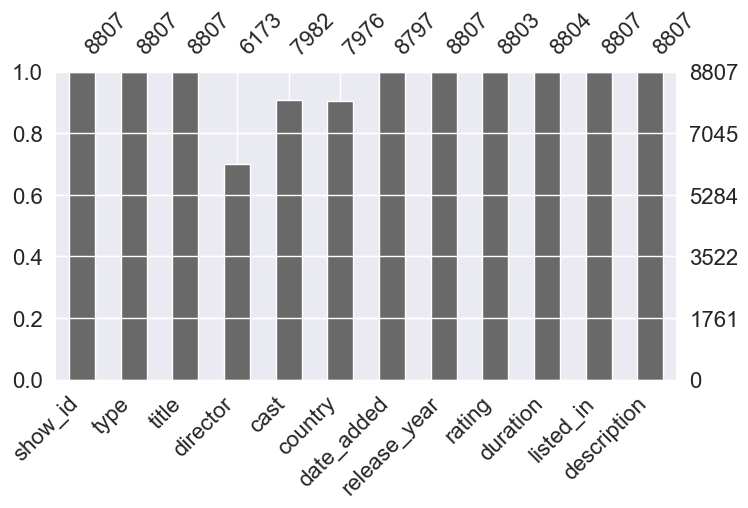

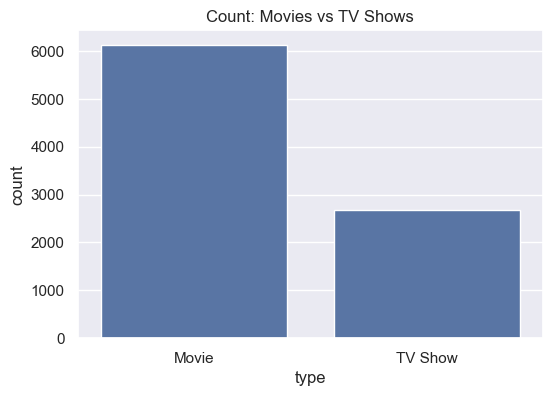

In [16]:
# Movies vs TV Shows count
plt.figure(figsize=(6,4))
sns.countplot(data=data, x='type')
plt.title('Count: Movies vs TV Shows')
plt.show()


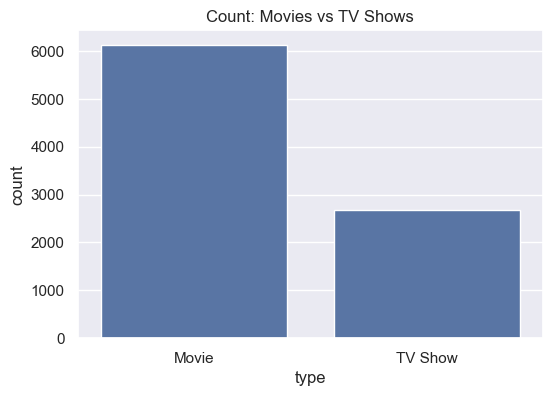

In [17]:
# Movies vs TV Shows count
plt.figure(figsize=(6,4))
sns.countplot(data=data, x='type')
plt.title('Count: Movies vs TV Shows')
plt.show()


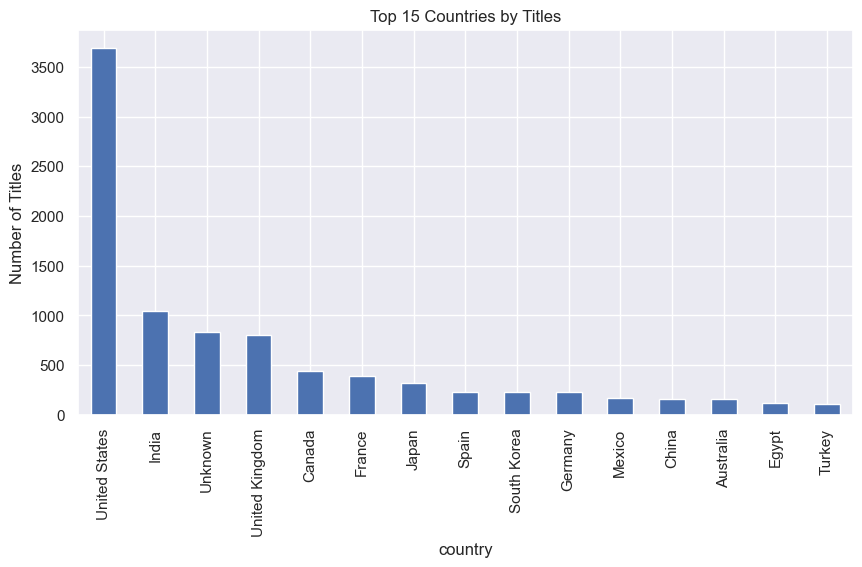

In [18]:
# Top countries
top_countries = data['country'].str.split(', ').explode().value_counts().head(15)
plt.figure(figsize=(10,5))
top_countries.plot(kind='bar')
plt.title('Top 15 Countries by Titles')
plt.ylabel('Number of Titles')
plt.show()


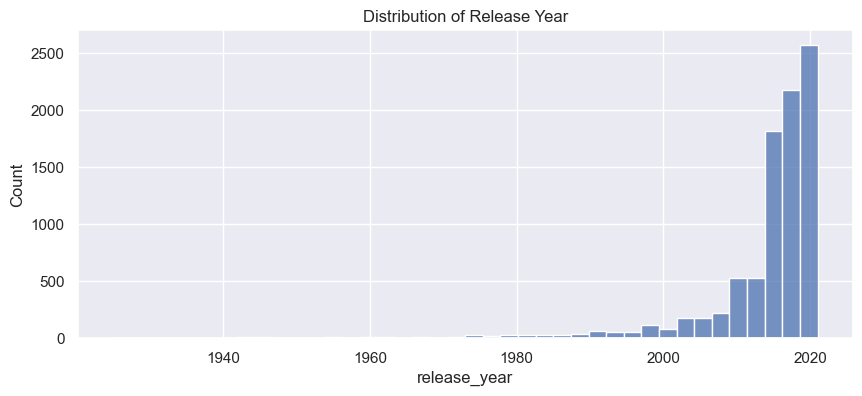

In [19]:
# Release year distribution
plt.figure(figsize=(10,4))
sns.histplot(data['release_year'].dropna(), bins=40)
plt.title('Distribution of Release Year')
plt.show()


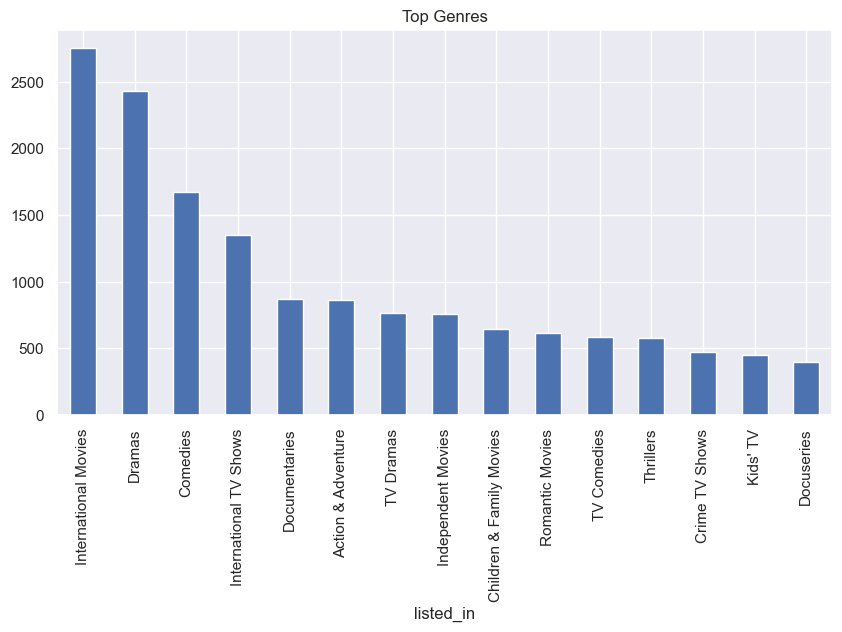

In [20]:
# Top genres (listed_in)
top_genres = data['listed_in'].str.split(', ').explode().value_counts().head(15)
plt.figure(figsize=(10,5))
top_genres.plot(kind='bar')
plt.title('Top Genres')
plt.show()


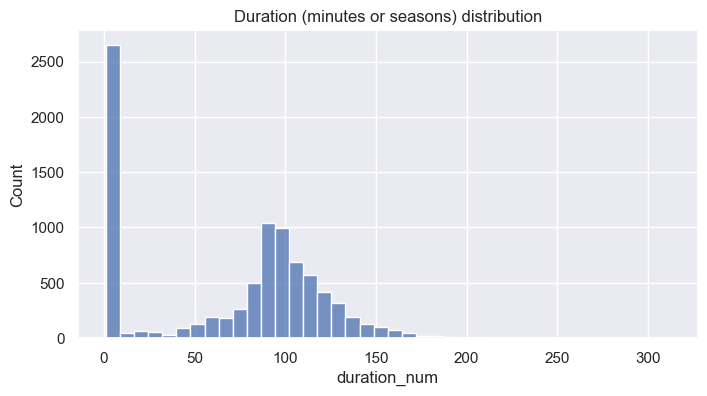

In [21]:
# Duration numeric distribution (movies minutes / tv seasons)
plt.figure(figsize=(8,4))
sns.histplot(data['duration_num'].dropna(), bins=40)
plt.title('Duration (minutes or seasons) distribution')
plt.show()


## Modeling Task 1: Classification — Predict whether a title is Movie (1) or TV Show (0)
- Use features: release_year, duration_num, num_listed_genres, rating (encoded), country (top n), TF-IDF of description (text)
- Build pipeline combining numeric, categorical and text


In [22]:
# Select subset and limit rare categories for country and rating to avoid too many dummies
data_model = data.copy()
# Fill duration_num with median
data_model['duration_num'] = data_model['duration_num'].fillna(data_model['duration_num'].median())
# Fill added_year with release_year if missing
data_model['added_year'] = data_model['added_year'].fillna(data_model['release_year'])

# Keep top N countries, group others into 'Other'
topN = 10
top_countries = data_model['country'].str.split(', ').explode().value_counts().head(topN).index.tolist()
def country_top(x):
    try:
        countries = str(x).split(', ')
        for c in countries:
            if c in top_countries:
                return c
        return 'Other'
    except:
        return 'Other'
data_model['country_top'] = data_model['country'].apply(country_top)
data_model['rating'] = data_model['rating'].fillna('Unknown')

# Features and target
features = ['duration_num', 'release_year', 'num_listed_genres', 'country_top', 'rating', 'description']
target = 'type_label'

X = data_model[features].fillna('')
y = data_model[target].astype(int)


In [23]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(X_train.shape, X_test.shape, y_train.value_counts(normalize=True))


(7045, 6) (1762, 6) type_label
1    0.696097
0    0.303903
Name: proportion, dtype: float64


In [24]:
# Column selectors
num_features = ['duration_num', 'release_year', 'num_listed_genres']
cat_features = ['country_top', 'rating']
text_feature = 'description'

# Numeric transformer
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Categorical transformer
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Text transformer (TF-IDF)
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english'))
])

# Combine with ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features),
    ('desc', text_transformer, text_feature)
], remainder='drop')


In [25]:
# Candidate models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=200, random_state=42)
}

# Train and evaluate
results = {}
for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('clf', model)])
    print(f"Training {name} ...")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    # Probabilities for roc if available
    y_proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe.named_steps['clf'], "predict_proba") else None
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }
    results[name] = {'model': pipe, 'metrics': metrics}
    print(name, metrics)
    print(classification_report(y_test, y_pred))
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    print('-'*50)


Training LogisticRegression ...
LogisticRegression {'accuracy': 0.9954597048808173, 'precision': 1.0, 'recall': 0.993480032599837, 'f1': 0.9967293540474244, 'roc_auc': 0.999899458446633}
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       535
           1       1.00      0.99      1.00      1227

    accuracy                           1.00      1762
   macro avg       0.99      1.00      0.99      1762
weighted avg       1.00      1.00      1.00      1762

Confusion matrix:
[[ 535    0]
 [   8 1219]]
--------------------------------------------------
Training RandomForest ...
RandomForest {'accuracy': 0.9994324631101021, 'precision': 1.0, 'recall': 0.9991850040749797, 'f1': 0.9995923359152059, 'roc_auc': 0.9999550609723586}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       535
           1       1.00      1.00      1.00      1227

    accuracy                           1.00      

In [26]:
# Summarize results
summary = {k: v['metrics'] for k,v in results.items()}
pd.DataFrame(summary).T


,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.995460,1.0,0.993480,0.996729,0.999899
RandomForest,0.999432,1.0,0.999185,0.999592,0.999955
GradientBoosting,0.997162,1.0,0.995925,0.997958,0.999958


In [27]:
# Choose best by F1 (example)
best_name = max(results.keys(), key=lambda k: results[k]['metrics']['f1'])
best_pipe = results[best_name]['model']
print("Best model:", best_name, results[best_name]['metrics'])
joblib.dump(best_pipe, 'netflix_type_classifier.joblib')


Best model: RandomForest {'accuracy': 0.9994324631101021, 'precision': 1.0, 'recall': 0.9991850040749797, 'f1': 0.9995923359152059, 'roc_auc': 0.9999550609723586}


['netflix_type_classifier.joblib']

## Modeling Task 2: Clustering — group similar titles
- Use TF-IDF on description, reduce dimensionality with SVD (LSA), then KMeans


In [28]:
# Prepare TF-IDF for descriptions (fit on all data)
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
desc_tfidf = tfidf.fit_transform(data['description'].fillna(''))

# Dimensionality reduction
svd = TruncatedSVD(n_components=100, random_state=42)
desc_reduced = svd.fit_transform(desc_tfidf)

# KMeans: choose k by silhouette (try range)
sil_scores = []
K_range = range(2,8)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(desc_reduced)
    sil = silhouette_score(desc_reduced, labels)
    sil_scores.append(sil)
    print(f"k={k}, silhouette={sil:.4f}")

# Choose best k
best_k = K_range[int(np.argmax(sil_scores))]
print("Best k by silhouette:", best_k)

# Fit final KMeans
km_final = KMeans(n_clusters=best_k, random_state=42)
clusters = km_final.fit_predict(desc_reduced)
data['cluster'] = clusters

# Show cluster sizes and top terms per cluster
data['cluster'].value_counts()


k=2, silhouette=0.0560
k=3, silhouette=0.0559
k=4, silhouette=0.0618
k=5, silhouette=0.0611
k=6, silhouette=0.0619
k=7, silhouette=0.0538
Best k by silhouette: 6


cluster
3    6356
1     713
4     637
0     553
2     360
5     188
Name: count, dtype: int64

In [29]:
# Top terms per cluster (approx) using cluster centroids in tf-idf space
centroids = km_final.cluster_centers_
terms = tfidf.get_feature_names_out()
for i, centroid in enumerate(centroids):
    top_idx = centroid.argsort()[-10:][::-1]
    top_terms = [terms[idx] for idx in top_idx]
    print(f"Cluster {i} top terms:", top_terms)


Cluster 0 top terms: ['000', '1950s', '1590', '18', '2011', '007', '1920s', '20th', '14', '30']
Cluster 1 top terms: ['000', '10', '16', '1590', '100', '13', '15', '17', '1960s', '18']
Cluster 2 top terms: ['000', '1992', '1996', '1999', '1971', '1980', '60', '2011', '007', '14']
Cluster 3 top terms: ['000', '1930s', '12', '20', '1970s', '13', '15', '1994', '25', '1971']
Cluster 4 top terms: ['11', '000', '10', '16th', '18', '20th', '1990s', '1996', '1994', '100']
Cluster 5 top terms: ['28', '000', '19th', '24', '2014', '2012', '40', '1990s', '80s', '1930s']


## Recommendation System — content-based using TF-IDF on descriptions
- Given a title, recommend N most similar titles by cosine similarity


In [30]:
# Build cosine similarity matrix (maybe compute on reduced vectors for speed)
cos_sim = cosine_similarity(desc_reduced)

# Map title to index
title_to_idx = pd.Series(data.index, index=data['title']).drop_duplicates()

def recommend(title, topn=10):
    if title not in title_to_idx:
        print("Title not found. Try exact title from dataset.")
        return []
    idx = title_to_idx[title]
    sim_scores = list(enumerate(cos_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:topn+1]  # exclude itself
    recs = [(data.iloc[i]['title'], float(score), data.iloc[i]['type'], data.iloc[i]['listed_in']) for i, score in sim_scores]
    return recs

# Example
example_title = data['title'].iloc[10]
print("Example title:", example_title)
recommendations = recommend(example_title, topn=8)
for r in recommendations:
    print(r)


Example title: Vendetta: Truth, Lies and The Mafia
('The Con Is On', 0.9083935310463294, 'Movie', 'Comedies')
('60 Days In', 0.8964361024344232, 'TV Show', 'Reality TV')
('Crime Scene: The Vanishing at the Cecil Hotel', 0.8925117231947459, 'TV Show', 'Crime TV Shows, Docuseries')
('Click for Murder', 0.8760376879186241, 'TV Show', 'British TV Shows, Crime TV Shows, Docuseries')
('Once Upon a Time in London', 0.8697321332421709, 'Movie', 'Dramas, International Movies')
('The Prison', 0.8618230267636623, 'Movie', 'Action & Adventure, Dramas, International Movies')
('Kill the Irishman', 0.8521118256780565, 'Movie', 'Action & Adventure, Dramas, Independent Movies')
('Intelligence', 0.836482002239578, 'TV Show', 'Crime TV Shows, TV Dramas')


## Evaluation & Discussion
- Classification metrics reported (Accuracy, Precision, Recall, F1, ROC-AUC)
- For imbalanced classes, emphasize Precision/Recall/F1 more than Accuracy
- Clustering validated via Silhouette Score and manual inspection of top terms per cluster
- Recommender evaluated qualitatively (manual inspection) — mention usage of Precision@K or MAP for production evaluation if user behavior data available


## Deployment & Ethics
**Deployment**
- Wrap classifier/recommender as a REST API using Flask/FastAPI
- Save vectorizers & models with joblib; load in API server
- Provide endpoints: /predict-type, /recommend?title=...

**Ethical & Practical Considerations**
- Bias in recommendations (over-representing popular content)
- Country or language bias (ensure diverse recommendations)
- Privacy: no PII present in this dataset, but when combining with user data, follow privacy rules
- Explainability: enable short explanation (e.g., key genres, top similar terms) for recommended items


In [31]:
# Save TF-IDF and SVD and KMeans for later use
joblib.dump(tfidf, 'tfidf_desc.joblib')
joblib.dump(svd, 'svd_desc.joblib')
joblib.dump(km_final, 'kmeans_clusters.joblib')
joblib.dump(title_to_idx, 'title_to_idx.joblib')

print("Saved models and artifacts.")


Saved models and artifacts.
